In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('mario.csv')

## pre-processing

In [11]:
data.shape

(660, 5)

In [4]:
data.head(20)

,team_id,phase,group,round,totalingred
0,21301,1,newhire,1,19
1,21301,1,newhire,2,23
2,21301,1,newhire,3,23
3,21301,1,newhire,4,25
4,21301,1,newhire,5,24
5,21301,1,newhire,6,27
6,21301,2,newhire,7,28
7,21301,2,newhire,8,28
8,21301,2,newhire,9,31
9,21301,2,newhire,10,28


In [7]:
## let's see how many are there
data['team_id'].nunique()

55

In [10]:
data.groupby('group')['team_id'].nunique()

group
ai         20
control    20
newhire    15
Name: team_id, dtype: int64

In [12]:
## now let's see if there is any kind of wierd attribute
data.dtypes

team_id         int64
phase           int64
group          object
round           int64
totalingred     int64
dtype: object

In [13]:
## if we need to change the typ of group in order to use some funstion we can replace the groupnames with -1,0,1

In [14]:
## now let's see if there are missing value
data.isna().sum()

team_id        0
phase          0
group          0
round          0
totalingred    0
dtype: int64

In [15]:
##good! but if there were, considering the fact we do not have enough data we could not drop them we probably had to replace them with the avrage or the mean

In [20]:
## now the most important part
data.groupby(['group','phase'])['totalingred'].describe()

count       mean       std   min    25%   50%    75%   max
group   phase                                                            
ai      1      120.0  23.125000  4.560633   9.0  21.00  23.0  26.00  33.0
        2      120.0  26.233333  3.379954  17.0  24.00  26.5  29.00  36.0
control 1      120.0  22.441667  4.250152  11.0  20.00  23.0  25.00  31.0
        2      120.0  26.750000  3.262339  18.0  25.00  27.0  28.25  34.0
newhire 1       90.0  23.444444  4.419342  13.0  21.25  24.0  27.00  33.0
        2       90.0  27.133333  3.892372  18.0  25.00  27.0  30.00  36.0

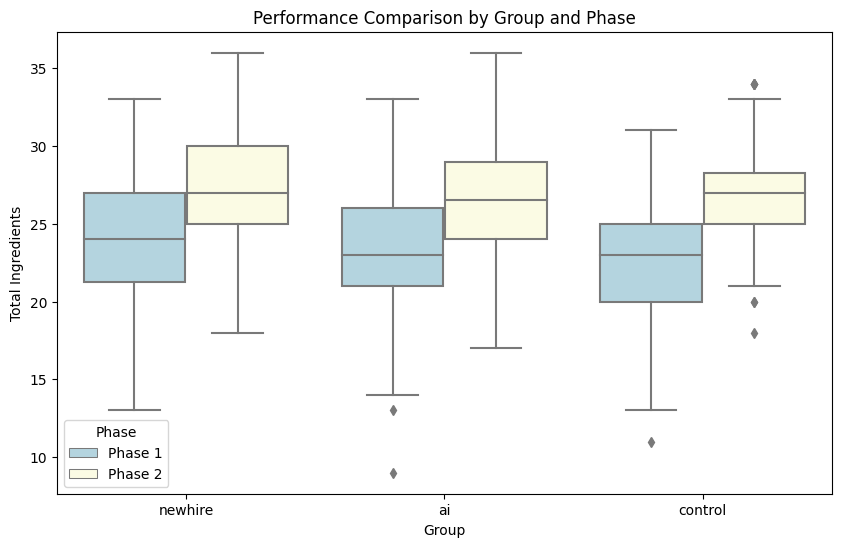

In [24]:
group_colors = {'control': 'blue', 'newhire': 'yellow', 'ai': 'blue'}
phase_colors = {1: 'lightblue', 2: 'lightyellow'}  # Different shades for each phase

# Box plot or violin plot to compare performance between groups in each phase
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='totalingred', hue='phase', data=data, palette=phase_colors, dodge=True)
plt.title('Performance Comparison by Group and Phase')
plt.xlabel('Group')
plt.ylabel('Total Ingredients')

# Customize legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f'Phase {label}' for label in labels]
plt.legend(handles, labels, title='Phase')

plt.show()

Slope for ai: 3.108333333333332
Slope for control: 4.308333333333332
Slope for newhire: 3.688888888888877


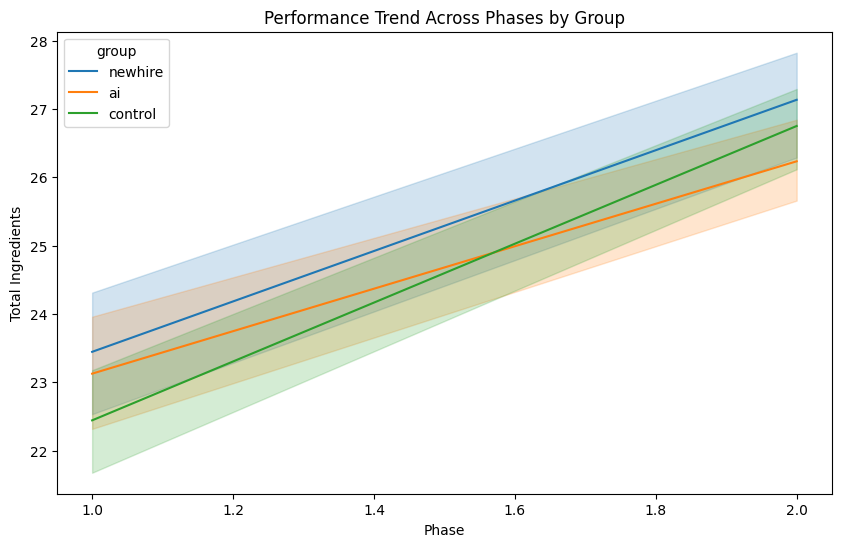

In [33]:
import numpy as np
plt.figure(figsize=(10, 6))
sns.lineplot(x='phase', y='totalingred', hue='group', data=data)

# Calculate slopes for each group
for group_name, group_data in data.groupby('group'):
    x = group_data['phase']
    y = group_data['totalingred']
    slope, intercept = np.polyfit(x, y, 1)
    print(f"Slope for {group_name}: {slope}")

plt.title('Performance Trend Across Phases by Group')
plt.xlabel('Phase')
plt.ylabel('Total Ingredients')
plt.show()

In [6]:
negative_values = (data['totalingred'] < 0).sum()
print(f"Number of negative values in 'totalingred': {negative_values}")


Number of negative values in 'totalingred': 0


In [22]:
import numpy as np
# Select 15 random groups from 'ai'
selected_ai_groups = np.random.choice(data[data['group'] == 'ai']['team_id'].unique(), size=15, replace=False)

# Select 15 random groups from 'control'
selected_control_groups = np.random.choice(data[data['group'] == 'control']['team_id'].unique(), size=15, replace=False)

newhire_groups = data[data['group'] == 'newhire']['team_id'].unique()
# Create a new DataFrame with the selected groups
balanced_data = data[data['team_id'].isin(np.concatenate([selected_ai_groups, selected_control_groups , newhire_groups]))]



In [23]:
# Perform ANOVA
formula = 'totalingred ~ C(phase) * C(group)'
model = ols(formula, data=balanced_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                        sum_sq     df           F        PR(>F)
C(phase)           1859.266667    1.0  115.142524  1.855914e-24
C(group)             83.344444    2.0    2.580719  7.666372e-02
C(phase):C(group)    23.544444    2.0    0.729042  4.828504e-01
Residual           8622.777778  534.0         NaN           NaN


In [24]:
# Check for degenerate groups
degenerate_groups = anova_table[anova_table['PR(>F)'].isna()].index
print("Degenerate groups:", degenerate_groups)

Degenerate groups: Index(['Residual'], dtype='object')


In [25]:
# Perform Tukey's HSD post hoc test
tukey_results = pairwise_tukeyhsd(endog=balanced_data['totalingred'], groups=balanced_data['group'], alpha=0.05)

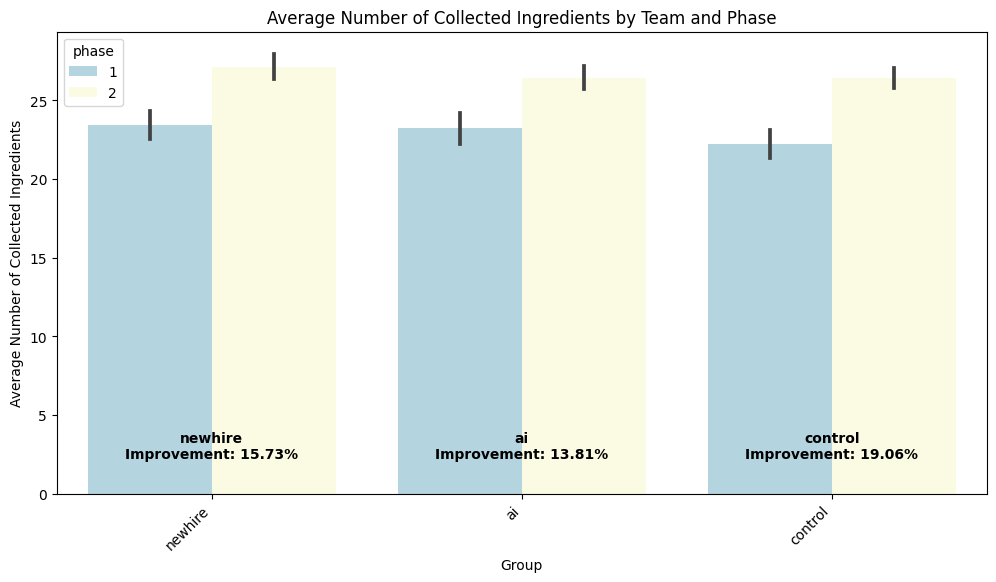

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
     ai control  -0.5222 0.5021  -1.618 0.5735  False
     ai newhire   0.4389 0.6143 -0.6569 1.5346  False
control newhire   0.9611  0.099 -0.1346 2.0569  False
-----------------------------------------------------
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
     ai control  -0.5222 0.5021  -1.618 0.5735  False
     ai newhire   0.4389 0.6143 -0.6569 1.5346  False
control newhire   0.9611  0.099 -0.1346 2.0569  False
-----------------------------------------------------


In [32]:
# Visualize the average performance of each team in each phase
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='group', y='totalingred', hue='phase', data=balanced_data)
sns.set_palette(['lightblue', 'lightyellow'])
plt.title('Average Number of Collected Ingredients by Team and Phase')
plt.xlabel('Group')
plt.ylabel('Average Number of Collected Ingredients')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Add text annotations for percentage improvement within each group
for i, group in enumerate(balanced_data['group'].unique()):
    first_round_mean = balanced_data[(balanced_data['phase'] == 1) & (balanced_data['group'] == group)]['totalingred'].mean()
    second_round_mean = balanced_data[(balanced_data['phase'] == 2) & (balanced_data['group'] == group)]['totalingred'].mean()
    percentage_improvement = ((second_round_mean - first_round_mean) / first_round_mean) * 100
    plt.text(i, 3, f'{group}\nImprovement: {percentage_improvement:.2f}%', ha='center', va='center', fontweight='bold')

plt.show()

# Print the results
print(tukey_results)

# Summary of significant differences
significant_diff = tukey_results.summary()
print(significant_diff)

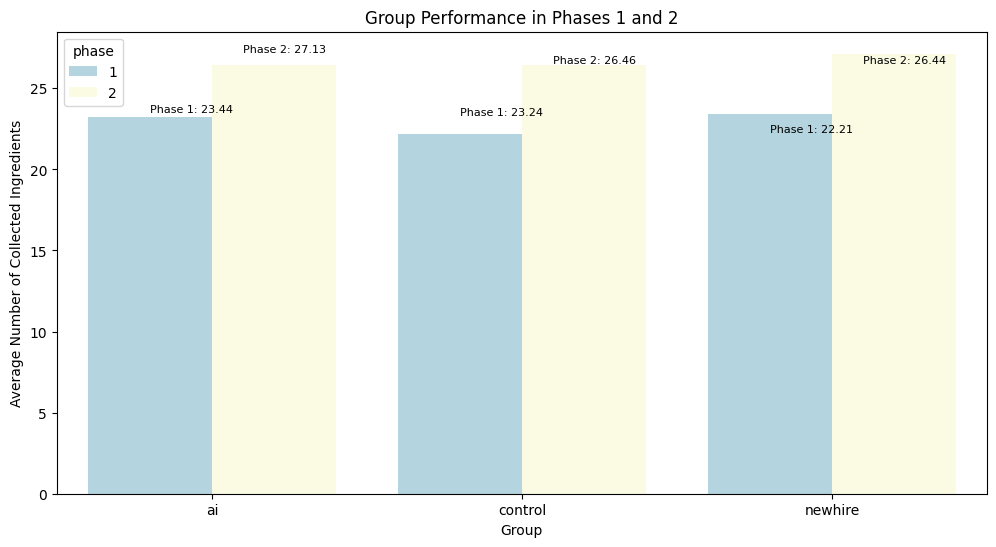

In [31]:
group_performance = balanced_data.groupby(['group', 'phase']).agg({'totalingred': 'mean'}).reset_index()

# Set the color palette to blue and yellow
sns.set_palette(['lightblue', 'lightyellow'])

# Create a bar plot with printed numbers
plt.figure(figsize=(12, 6))
sns.barplot(x='group', y='totalingred', hue='phase', data=group_performance)
plt.title('Group Performance in Phases 1 and 2')
plt.xlabel('Group')
plt.ylabel('Average Number of Collected Ingredients')

# Print numbers on the bars
for i, group in enumerate(balanced_data['group'].unique()):
    phase1_mean = balanced_data[(balanced_data['group'] == group) & (balanced_data['phase'] == 1)]['totalingred'].mean()
    phase2_mean = balanced_data[(balanced_data['group'] == group) & (balanced_data['phase'] == 2)]['totalingred'].mean()

    plt.text(i - 0.2, phase1_mean + 0.1, f'Phase 1: {phase1_mean:.2f}', fontsize=8, color='black')
    plt.text(i + 0.1, phase2_mean + 0.1, f'Phase 2: {phase2_mean:.2f}', fontsize=8, color='black')

plt.show()